In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from scipy.special import expit
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
# print(os.getcwd())

# Logistic Regression

Logistic Regression is used for classification type problems which have a discrete outcome. Examples are:

- Pass/Fail
- Tall/Short
- Default/No-Default
- Approved/Denied


## Background

With logistic regression we are trying to model the probability of success (y=1) given one or more explanatory variables. The y-axis is the probability of the observation being classified as a success given the inputs. This means the y-axis spans from 0 to 1, which requires a function to transform the input variables into this span. 

- Cannot have negative probability
- Cannot have a probability greater than 1

The logistic function does this transformation for us

$
p(x) = \frac{1}{1+e^{-(\beta_0 + \beta_1 x)}}
$

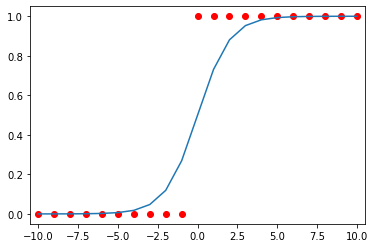

In [2]:
# Plot logit function
x = np.arange(-10,11,1)
y = 1/(1+np.exp(-x))
yobs = np.where(x<0, 0, 1)

plt.plot(x, y)
plt.scatter(x,yobs, color='r')
plt.xlim([-10.5, 10.5])
plt.show()

## Study Hours Demo

In [3]:
df = pd.read_csv("ExData\score.csv")
print(df.head())
print(df.describe())

df['outcome'] = np.where(df['Scores'] > 50, 1, 0)
print(df.head())

   Hours  Scores
0    2.5      21
1    5.1      47
2    3.2      27
3    8.5      75
4    3.5      30
           Hours     Scores
count  27.000000  27.000000
mean    4.900000  52.259259
std     2.474951  24.720892
min     1.100000  17.000000
25%     2.700000  30.000000
50%     4.500000  49.000000
75%     7.150000  75.000000
max     9.200000  95.000000
   Hours  Scores  outcome
0    2.5      21        0
1    5.1      47        0
2    3.2      27        0
3    8.5      75        1
4    3.5      30        0


Using a simple dataset of hours study vs test outcome.

In this graph, the y-axis is the probability of success given the input(s) for x. To estimate the model, we need to find the values for $\beta$ that give the highest likelihood of observing the data. Let us consider an example with hours of study and whether a student passes a test. 

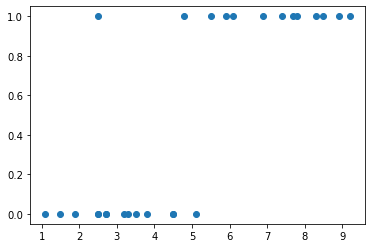

In [4]:
plt.scatter(df['Hours'], df['outcome'])
plt.show()

We can see that there is some relationship between the hours of study and whether a student passes their test or not. Consider the case of when a student studies for four hours, the likelihood of them passing is given by $p(X)$ where X is the number of hours they studied. Assume that studying for 4 hours gives a 0.25 probability of passing and we are checking a case where they failed.


$$
\begin{align*}
& p(4) = 0.25 \\
& log(p(4)) = -1.39 \\
& log(1 - p(4)) = -0.29 \\
& y = 0 \\
& likelihood = -y_i \log(p(X_i)) - (1 - y_i) \log(1 - p(X_i)) \\
& likelihood = -0 * (-1.39) - 1 * (-0.29) = 0.29 \\
\end{align*}
$$

In words, we are checking each point to see if fits better in the pass or fail group based on the estimated probability of passing. If we checked an observation where they passed with four hours of study we get a larger positive likelihood. The model will try to minimize the likelihood value for all data points.

$$
\begin{align*}
& p(4) = 0.25 \\
& log(p(4)) = -1.39 \\
& log(1 - p(4)) = -0.29 \\
& y = 1 \\
& likelihood = -y_i \log(p(X_i)) - (1 - y_i) \log(1 - p(X_i)) \\
& likelihood = -1 * (-1.39) - 0 * (-0.29) = 1.39 \\
\end{align*}
$$

If there are many observations with students passing with 4 hours of study, we would need to update our estimate for the $p(X)$ function to better reflect the data.

We achieve this by performing the calculation for every observation and find the set of coefficients that minimizes the objective (loss) function:

$
\min_{\beta} \sum_{i=1}^n \left(-y_i \log(p(X_i)) - (1 - y_i) \log(1 - p(X_i))\right)
$

If you are looking for some intuition behind this formula, this formula looks very similar to the likelihood of a bernoulli trial. This is done using a method called maximum likelihood which is solved using an optimization algorithm. 

Good link on solvers:
https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions

In [5]:
#Note when fitting most models in sklearn, the x-values need to be in a 2-d matrix
    #df['column'].values provides a series in a 1-d array
    #by adding .reshape(-1,1) reconfigured the array into a matrix
    
#df['Hours'].values
#df['Hours'].values.reshape(-1,1)
df['Hours'].values.shape, df['Hours'].values.reshape(-1,1).shape, df[['Hours']].shape

((27,), (27, 1), (27, 1))

In [6]:
X = df['Hours'].values.reshape(-1,1)
y = df['outcome'].values
clf = LogisticRegression(random_state=0)  # clf for classifier
clf.fit(X, y)  # X=predictors, Y=target

LogisticRegression(random_state=0)

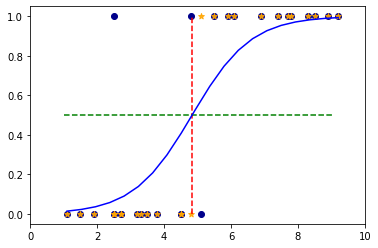

In [7]:
X_axis_values = np.linspace(df['Hours'].min(), df['Hours'].max(), 20)
y_sig = expit(X_axis_values * clf.coef_ + clf.intercept_).ravel()
plt.scatter(df['Hours'], df['outcome'], color='darkblue', marker='o')
plt.scatter(df['Hours'], clf.predict(X), color='orange', marker='*', alpha=0.9) #predictions
plt.plot(X_axis_values, y_sig, color='b')
mid_point = (np.log(1/0.5 - 1) - clf.intercept_)/clf.coef_
plt.vlines(mid_point, ymin=0, ymax=1, color='r', linestyles='--')
plt.hlines(0.5, xmin=1, xmax=9, color='g', linestyles='--')
plt.xlim([0, 10])
plt.show()

In [8]:
mid_point

array([[4.83637461]])

In dark blue dots are the actual outcomes and the orange stars are the predicted results. You can see from the graph that the classifier makes a cutoff at 5 hours for pass. 

Notice that there are two outliers that would get miss-classified. There are two passes below the cutoff that are incorrectly classified as fails (False Negatives) and one fail above the cutoff classified as a pass (False Positive). 

How do we determine how well a model performs?

We can check the score which measures the accuracy of the model.

In [9]:
clf.score(X, y)  # Average Score accuracy
    #X = hours column, y = outcome column

0.8888888888888888

The formula for Accuracy is

$
Accuracy = \frac{TP+TN}{TP+TN+FP+FN}
$

TP is True Positives and TN is True Negatives. There are observations that are correctly classified. FP is False Positive, which are observations that are incorrectly predicted as Positive, and FN is False Negative are observations that are incorrectly predicted as Negative. These can be visualized using the confusion matrix.

In [10]:
confusion_matrix(y, clf.predict(X))  

array([[13,  1],
       [ 2, 11]], dtype=int64)

Confusion Matrix is organized as follows (row is input, column is output):

|           |       |**Predicted**    | **Predicted**   |
|:---------:|:-----:|:---------------:|:---------------:|
|           |       |      **0**      |      **1**      |
| **Actual**| **0** | True Negatives  | False Positives |
| **Actual**| **1** | False Negatives | True Positives  |

- False Negatives are also known as Type II Errors
- False Positives are also known as Type I Errors

Further metrics can be generated for model valuation. When looking along the positive outcome row

- **Precision** is the ratio of true positives (TP) to predicted positives (TP + FP). This tells you how likely the model is to incorrectly generate a false positive.
    - $Precision = \frac{TP}{TP+FP}$
- **Recall** is the ratio of true positives to false negatives (FN) and true positives (TP). This tells you how well the model is to find a positive result.    
    - $Recall = \frac{TP}{TP+FN}$
    - also called "Sensitivity" or "True Positive Rate (TPR)"



In [11]:
print(classification_report(y, clf.predict(X)))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90        14
           1       0.92      0.85      0.88        13

    accuracy                           0.89        27
   macro avg       0.89      0.89      0.89        27
weighted avg       0.89      0.89      0.89        27



These are a based on a threshold of 0.5, how does the model perform if the threshold changes?

(0.0, 1.0)

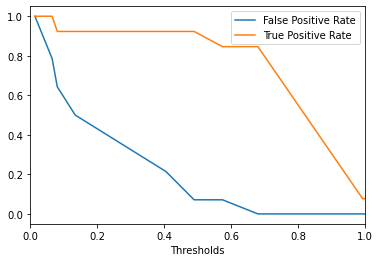

In [12]:
# predict_proba() returns prob of y=0, prob of y=1
y_prob = clf.predict_proba(X)[:, 1] #extract just the probabilities of y=1
fpr, tpr, thresholds = roc_curve(y, y_prob)

plt.plot(thresholds, fpr)
plt.plot(thresholds, tpr)
plt.xlabel("Thresholds")
plt.legend(['False Positive Rate', 'True Positive Rate'])
plt.xlim(0,1)  # roc_curve() sets high threshold at y_prob.max() + 1

You can see at threshold below 0.5 the False Positive rate increases, but above 0.5 the False Positive will decrease while decreasing True Positive rate significantly. There is always a trade off.

0.9395604395604397


Text(0, 0.5, 'True Positive Rate')

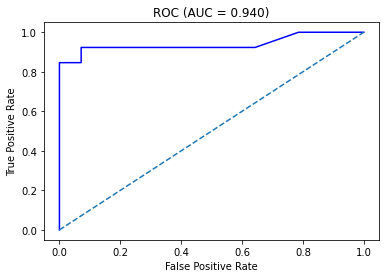

In [13]:
clf_auc = auc(fpr, tpr)
print(clf_auc)

plt.plot(fpr, tpr, color='b')
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), linestyle="--")
plt.title(r"ROC (AUC = {:.3f})".format(clf_auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

The 45 degree line represents a random classifier. The further the ROC curve moves towards the upper left, the "better" the classifier performs on average under different threshold levels. This graph highlights the trade offs between TP and FP. 

## Car Purchase Dataset

Going to work through a common EDA on a new dataset to prepare to train a model.

In [14]:
df = pd.read_csv("ExData\car_data.csv")
df.sort_values(['User ID']).head(10)

,User ID,Gender,Age,AnnualSalary,Purchased
960,1,Male,32,100000,1
464,2,Female,38,63500,0
619,3,Male,20,74000,0
761,4,Female,48,119000,1
494,5,Male,41,108500,1
668,6,Female,36,45500,0
650,7,Female,51,134000,0
699,8,Female,54,26000,1
578,9,Male,46,33500,1
327,10,Male,24,64500,0


In [15]:
df.set_index(["User ID"], inplace=True)

In [16]:
df.describe()

,Age,AnnualSalary,Purchased
count,1000.000000,1000.000000,1000.000000
mean,40.106000,72689.000000,0.402000
std,10.707073,34488.341867,0.490547
min,18.000000,15000.000000,0.000000
25%,32.000000,46375.000000,0.000000
50%,40.000000,72000.000000,0.000000
75%,48.000000,90000.000000,1.000000
max,63.000000,152500.000000,1.000000


We can get a visual representation of how the data is distributed unconditionally and conditionally based on whether the individual purchased a vehicle or not.

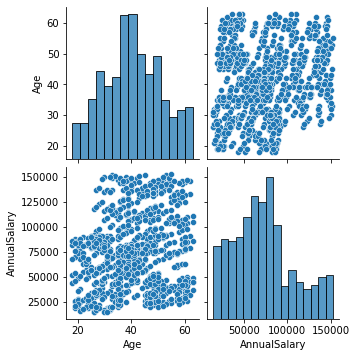

In [17]:
sns.pairplot(df[['Age', 'AnnualSalary']])

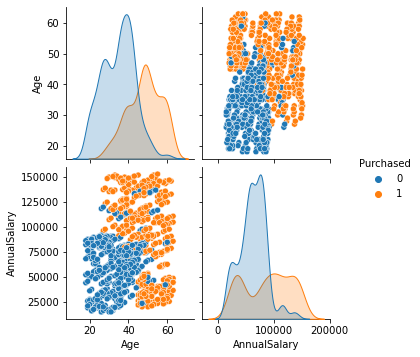

In [18]:
sns.pairplot(df, hue='Purchased')

Notice that there does appear to be clustering in the data, that individuals who are younger have lower incomes and tend not to purchase. Let's generate a model that uses these two predictors.

In [19]:
#We'll be re-using the following x and y variables
X = df[['Age','AnnualSalary']].values
y = df['Purchased'].values

In [20]:
# Even the function is useless, try adding age as a predictor
clf = LogisticRegression(random_state=0)
clf.fit(X, y)
# clf.fit(df[['Age', 'AnnualSalary']].values, df['Purchased'].values)

print(clf.score(X, y))
print(confusion_matrix(y, clf.predict(X)))

0.598
[[598   0]
 [402   0]]


In [21]:
clf.coef_

array([[-3.95606731e-09, -5.90142333e-07]])

The model appears to be just better than a coin flip? What is going on? Let's investigate with just Annual Salary so we can plot the sigmoid function.

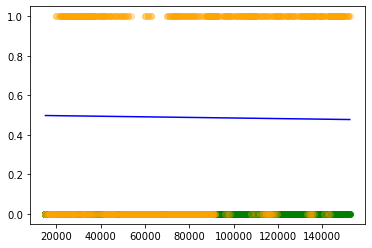

In [22]:
clf = LogisticRegression(random_state=0)
X_salary = df['AnnualSalary'].values.reshape(-1,1) 
clf.fit(X_salary, y)

# Plot the sigmoid function, predicted outcome
X_test = np.linspace(df['AnnualSalary'].min(), df['AnnualSalary'].max(), 20)
y_sig = expit(X_test * clf.coef_ + clf.intercept_).ravel()
plt.scatter(df['AnnualSalary'], clf.predict(X_salary), color='green')
plt.scatter(df['AnnualSalary'], df['Purchased'], color='orange', alpha=0.3)
plt.plot(X_test, y_sig, color='b')
plt.show()

It's a straight line, but we can visually see that there should be a relationship. There is an issue with the magnitude of annual salary, the values and variance are large which will dominate the gradient in the optimization algorithm. Another issue could be with numerical errors because of how computers do math. To overcome this issue, we can either normalize or standardize annual salary.

In [23]:
print(clf.coef_)
print(clf.intercept_)
print(np.spacing(np.float64(df['AnnualSalary'].mean())))
print(df['AnnualSalary'].mean() * clf.coef_ + clf.intercept_)
print((df['AnnualSalary'].mean()/1e5 * clf.coef_) * 1e5 + clf.intercept_)
print(expit(df['AnnualSalary'].mean() * clf.coef_ + clf.intercept_))
print(expit((df['AnnualSalary'].mean()/1e5 * clf.coef_) * 1e5 + clf.intercept_))


[[-5.9038432e-07]]
[-3.84708062e-10]
1.4551915228366852e-11
[[-0.04291445]]
[[-0.04291445]]
[[0.48927303]]
[[0.48927303]]


<AxesSubplot:xlabel='AnnualSalary', ylabel='Count'>

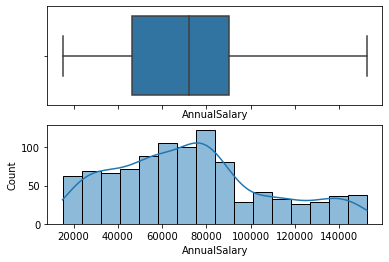

In [24]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True)
sns.boxplot(data = df, x='AnnualSalary', ax=ax_box)
sns.histplot(data = df, x='AnnualSalary', ax=ax_hist, kde=True)

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
df['AnnualSalaryStd'] = StandardScaler().fit_transform(df['AnnualSalary'].values.reshape(-1,1)) #z-scores
df['AnnualSalaryScaled'] = MaxAbsScaler().fit_transform(df['AnnualSalary'].values.reshape(-1,1)) #xi / max(all x)

In [26]:
df.head()

,Gender,Age,AnnualSalary,Purchased,AnnualSalaryStd,AnnualSalaryScaled
User ID,,,,,,
385,Male,35,20000,0,-1.528498,0.131148
681,Male,40,43500,0,-0.846767,0.285246
353,Male,49,74000,0,0.038032,0.485246
895,Male,40,107500,1,1.009861,0.704918
661,Male,25,79000,0,0.183081,0.518033


In [27]:
#example of MaxAbsScaler
#df['AnnualSalary']/df['AnnualSalary'].max()

#example of StandardScaler
# (df['AnnualSalary'] - df['AnnualSalary'].mean()) / df['AnnualSalary'].std(ddof=0) #0 degrees of freedom

<AxesSubplot:xlabel='AnnualSalaryStd', ylabel='Count'>

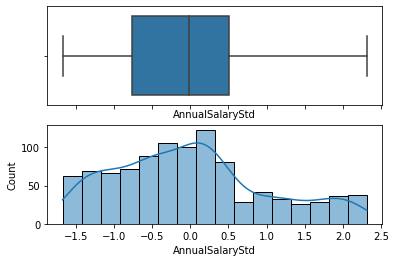

In [28]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True)
sns.boxplot(data = df, x='AnnualSalaryStd', ax=ax_box)
sns.histplot(data = df, x='AnnualSalaryStd', ax=ax_hist, kde=True)

<AxesSubplot:xlabel='AnnualSalaryScaled', ylabel='Count'>

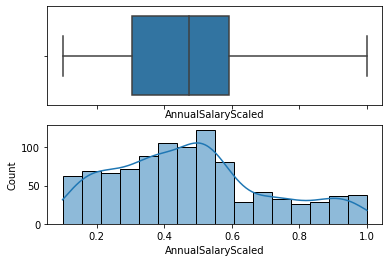

In [29]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True)
sns.boxplot(data = df, x='AnnualSalaryScaled', ax=ax_box)
sns.histplot(data = df, x='AnnualSalaryScaled', ax=ax_hist, kde=True)

Check that the distribution is still maintained. 

In [30]:
df.describe()

,Age,AnnualSalary,Purchased,AnnualSalaryStd,AnnualSalaryScaled
count,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000
mean,40.106000,72689.000000,0.402000,8.541778e-18,0.476649
std,10.707073,34488.341867,0.490547,1.000500e+00,0.226153
min,18.000000,15000.000000,0.000000,-1.673547e+00,0.098361
25%,32.000000,46375.000000,0.000000,-7.633642e-01,0.304098
50%,40.000000,72000.000000,0.000000,-1.998776e-02,0.472131
75%,48.000000,90000.000000,1.000000,5.021889e-01,0.590164
max,63.000000,152500.000000,1.000000,2.315302e+00,1.000000


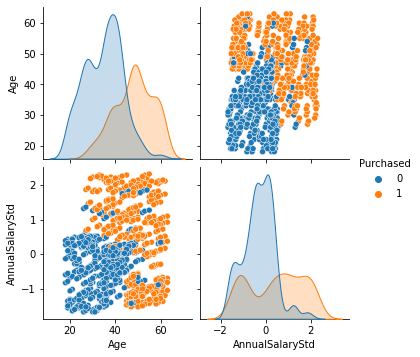

In [31]:
sns.pairplot(df[['Age', 'AnnualSalaryStd', 'Purchased']], hue='Purchased')

You can see that the relationship is maintained but the numbers are more friendly now.

In [32]:
clf = LogisticRegression(random_state=0)
clf.fit(df[['AnnualSalaryStd']].values, df['Purchased'].values)

LogisticRegression(random_state=0)

In [33]:
clf.score(df[['AnnualSalaryStd']].values, df['Purchased'].values)

0.771

In [34]:
confusion_matrix(df['Purchased'].values, clf.predict(df[['AnnualSalaryStd']].values))

array([[566,  32],
       [197, 205]], dtype=int64)

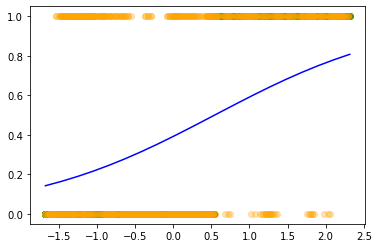

In [35]:
X_test = np.linspace(df['AnnualSalaryStd'].min(), df['AnnualSalaryStd'].max(), 20)
y_sig = expit(X_test * clf.coef_ + clf.intercept_).ravel()
plt.scatter(df['AnnualSalaryStd'], clf.predict(df['AnnualSalaryStd'].values.reshape(-1,1)), color='green')
plt.scatter(df['AnnualSalaryStd'], df['Purchased'], color='orange', alpha=0.3)
plt.plot(X_test, y_sig, color='b')
plt.show()

In [36]:
clf = LogisticRegression(random_state=0)
# if you set the penalty function to none, penalty='none', the performance improves to be the same as above
#clf = LogisticRegression(random_state=0, penalty='none')

clf.fit(df[['AnnualSalaryScaled']].values, df['Purchased'].values)
print(clf.score(df[['AnnualSalaryScaled']].values, df['Purchased'].values))
print(confusion_matrix(df['Purchased'].values, clf.predict(df[['AnnualSalaryScaled']].values)))

0.764
[[568  30]
 [206 196]]


Now we have a function that is useable at classification (not a horizontal line).
Notice that we have a categorical variable for gender (Male/Female). This needs to be converted into an indicator variable (dummy) if we want to use it in our model.

In [37]:
df = pd.concat([df, pd.get_dummies(df['Gender'])], axis=1)

In [38]:
df.head()

,Gender,Age,AnnualSalary,Purchased,AnnualSalaryStd,AnnualSalaryScaled,Female,Male
User ID,,,,,,,,
385,Male,35,20000,0,-1.528498,0.131148,0,1
681,Male,40,43500,0,-0.846767,0.285246,0,1
353,Male,49,74000,0,0.038032,0.485246,0,1
895,Male,40,107500,1,1.009861,0.704918,0,1
661,Male,25,79000,0,0.183081,0.518033,0,1


Now you can use either the Female or Male indicator variables in the model. 

## Test-Train Split

So far we have been judging performance of the model using the full dataset, however we don't know how well the model performs with unseen data.

We can simulate this by splitting the dataset into two parts, a training dataset which is used to estimate the model parameters and a test dataset that is used the evaluate the model performance.


In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(df['AnnualSalaryStd'], df['Purchased'], test_size=0.25, random_state=42)

In [41]:
clf = LogisticRegression(random_state=0)
clf.fit(X_train.values.reshape(-1,1), y_train.values)

LogisticRegression(random_state=0)

We can check in-sample performance and compare to out of sample performance

In [42]:
print(classification_report(y_train.values, clf.predict(X_train.values.reshape(-1,1))))

              precision    recall  f1-score   support

           0       0.75      0.95      0.84       460
           1       0.86      0.50      0.63       290

    accuracy                           0.77       750
   macro avg       0.80      0.72      0.73       750
weighted avg       0.79      0.77      0.76       750



In [43]:
print(classification_report(y_test.values, clf.predict(X_test.values.reshape(-1,1))))

              precision    recall  f1-score   support

           0       0.68      0.96      0.80       138
           1       0.89      0.45      0.60       112

    accuracy                           0.73       250
   macro avg       0.79      0.70      0.70       250
weighted avg       0.78      0.73      0.71       250



We can see that the model performance diminishes slightly with the test (unseen) data. This is expected, which is why we test against unseen data to check if the model is over fitted (memorizing).

The splitting is done randomly, so it maybe important that the two datasets are representative of the population. For instance the test data has 44.8% purchases were the training data has 38.7%. This is fairly close, but the model was trained on data with less likelihood of purchases which could bias the training. There is no one-size fits all but things to consider for this particular dataset.

- Think of conditional distribution, are the maintained when split
- Age distribution, Age-AnnualSalary distribution
- Proportion of Female to Male

At a minimum you would want to test different random_seeds to see if the model performance is not heavily tied to a particular train/test split.